
# Audio Classification - Self Project

By the end of this notebook, you will understand how to-

* Work with the audio data
* Represent an audio data - Time Domain and Spectrogram
* Build a deep learning model while working with audio data

<br>

# Understanding the Problem Statement

According to the National Crime Records Bureau, nearly 24,012 people die each day due to a delay in getting medical assistance. Many accident victims wait for help at the site, and a delay costs them their lives. The reasons could range from ambulances stuck in traffic to the fire brigade not being able to reach the site on time due to traffic jams.

The solution to the above problem is to create a system that automatically detects the emergency vehicle prior to reaching the traffic signals and change the traffic signals accordingly.

<br>

# Dataset

Download the dataset from [here](https://drive.google.com/file/d/1VBI_X6GyYvf8j3T70-_hVDyhR_sUzeCr/view?usp=sharing)

<br>

## Import Libraries

Let us first import the libraries into our environment

* **Librosa** is an open source library in Python that is used for audio and music analyis

* **Scipy** is a python library for scientific & technical computing. It contains modules for signal processing, image processing, and linear algebera

In [1]:
# For audio processing
import librosa
import scipy

In [2]:
librosa.__version__

'0.10.2.post1'

In [3]:
scipy.__version__

'1.11.4'

In [4]:
# For playing audio
import IPython.display as ipd

# For array processing
import numpy as np

# For visualization
import matplotlib.pyplot as plt

# Load Audio Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# extract data
!unzip '/content/drive/MyDrive/Audio/audio.zip'

Archive:  /content/drive/MyDrive/Audio/audio.zip
  inflating: non emergency.wav       
  inflating: __MACOSX/._non emergency.wav  
  inflating: emergency.wav           
  inflating: __MACOSX/._emergency.wav  


In [7]:
# import emergency vehicle data
path='emergency.wav'
emergency,sample_rate = librosa.load(path, sr = 16000)

# import non-emergency vehicle data
path='non emergency.wav'
non_emergency,sample_rate = librosa.load(path, sr =16000)

We have used the sampling rate (sr) of 16000 to read the above audio data. An audio wave of 2 seconds with a sampling rate of 16,000 will have 32,000 samples.

__Find the duration of the audio clips__

In [8]:
duration1 = librosa.get_duration(y = emergency,sr=16000)
duration2 = librosa.get_duration(y = non_emergency,sr=16000)

print("Duration of an emergency and Non Emergency (in min):",duration1/60,duration2/60)

Duration of an emergency and Non Emergency (in min): 22.920290625 27.160834375


## Preparing Data

Let us break the audio into chunks of 2 seconds. So, let us define the function for the same task

In [9]:
def prepare_data(audio_data, num_of_samples=32000, sr=16000):

  data=[]
  for offset in range(0, len(audio_data), sr):
    start = offset
    end   = offset + num_of_samples
    chunk = audio_data[start:end]

    if(len(chunk)==32000):
      data.append(chunk)

  return data

Call the above function

In [10]:
# prepare audio chunks
emergency = prepare_data(emergency)
non_emergency = prepare_data(non_emergency)

In [11]:
print("No. of Chunks of Emergency and Non Emergency:",len(emergency),len(non_emergency))

No. of Chunks of Emergency and Non Emergency: 1374 1628


Lets listen to some of the clips

In [12]:
ipd.Audio(emergency[136],rate=16000)

In [13]:
ipd.Audio(non_emergency[10],rate=16000)

## Visualization of Audio Data

Let's visualize the audio wave in time domain

Text(0, 0.5, 'Amplitude')

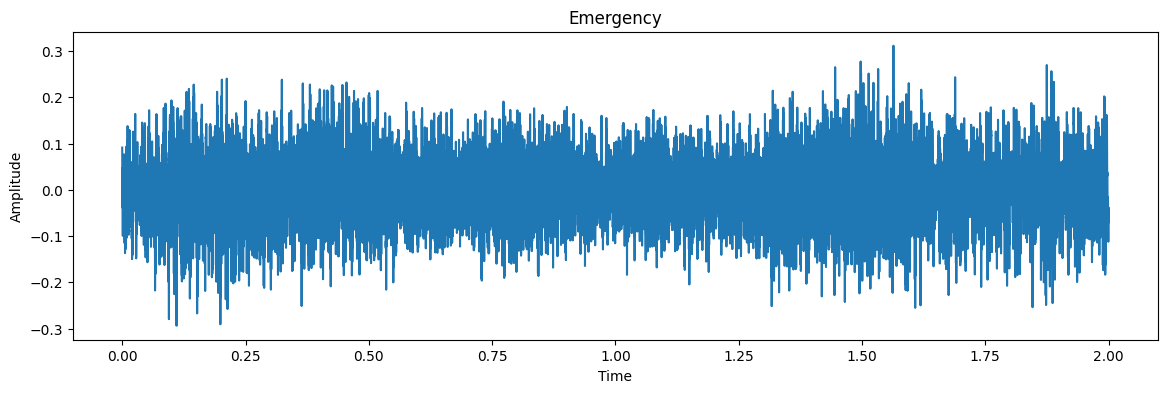

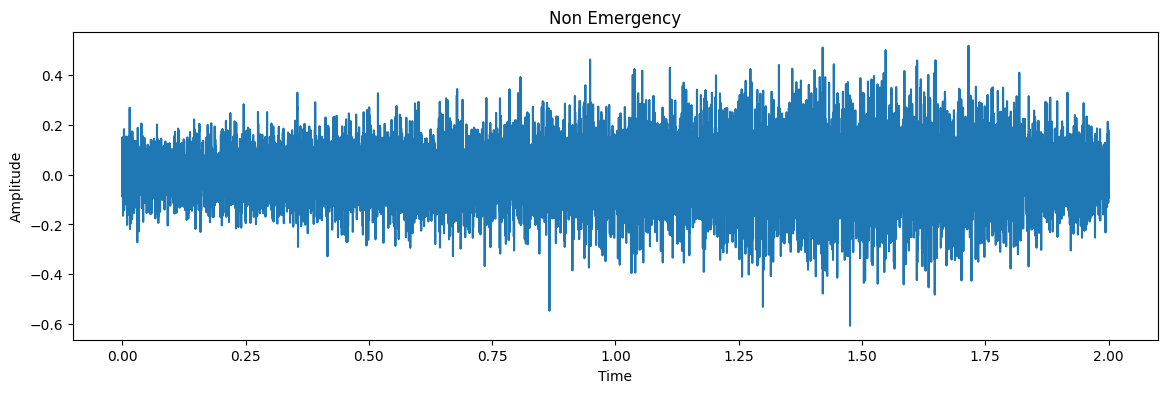

In [14]:
plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),emergency[103])
plt.title('Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.figure(figsize=(14,4))
plt.plot(np.linspace(0, 2, num=32000),non_emergency[102])
plt.title('Non Emergency')
plt.xlabel('Time')
plt.ylabel('Amplitude')

__Combine Emergecy and Non Emergency chunks__

In [15]:
audio = np.concatenate([emergency,non_emergency])

In [16]:
# assign labels
labels1 = np.zeros(len(emergency))
labels2 = np.ones(len(non_emergency))

# concatenate labels
labels = np.concatenate([labels1,labels2])

Take a glance at the shape of the combined data.

In [17]:
print(audio.shape)

(3002, 32000)


**Split into train and validation set**

Next, we will train the model on 90% of the data and validate on the remaining 10%:

In [18]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(audio),np.array(labels),
                                            stratify=labels,test_size = 0.1,
                                            random_state=777,shuffle=True)

In [19]:
x_tr.shape, x_val.shape

((2701, 32000), (301, 32000))

The input must be 3 dimensional array - (no. of examples, timesteps, features)

So, lets reshape our input array according to the required shape

In [20]:
x_tr_features  = x_tr.reshape(len(x_tr),-1,1)
x_val_features = x_val.reshape(len(x_val),-1,1)

print("Reshaped Array Size",x_tr_features.shape)

Reshaped Array Size (2701, 32000, 1)


## Model Architecture

Let's define the model architecture using conv1D layers  and the time domain features.

In [21]:
from keras.layers import Input, Conv1D, Dropout, MaxPooling1D, GlobalMaxPool1D, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint

# CNN based deep learning model architecture
def conv_model(x_tr):

  inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))

  #First Conv1D layer
  conv = Conv1D(8, 13, padding='same', activation='relu')(inputs)
  conv = Dropout(0.3)(conv)
  conv = MaxPooling1D(2)(conv)

  #Second Conv1D layer
  conv = Conv1D(16, 11, padding='same', activation='relu')(conv)
  conv = Dropout(0.3)(conv)
  conv = MaxPooling1D(2)(conv)

  # Global MaxPooling 1D
  conv = GlobalMaxPool1D()(conv)

  #Dense Layer
  conv = Dense(16, activation='relu')(conv)
  outputs = Dense(1,activation='sigmoid')(conv)

  model = Model(inputs, outputs)

  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
  model_checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

  return model, model_checkpoint

__Call the model__

In [22]:
model, model_checkpoint = conv_model(x_tr_features)

Understand the shape and parameters at each layer

In [23]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32000, 1)]        0         
                                                                 
 conv1d (Conv1D)             (None, 32000, 8)          112       
                                                                 
 dropout (Dropout)           (None, 32000, 8)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 16000, 8)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 16000, 16)         1424      
                                                                 
 dropout_1 (Dropout)         (None, 16000, 16)         0         
                                                             

Lets train the model for 10 epochs:

In [24]:
# model training
history = model.fit(x_tr_features, y_tr ,epochs=10,
                    callbacks=[model_checkpoint], batch_size=32,
                    validation_data=(x_val_features,y_val))

Epoch 1/10
85/85 [==============================] - ETA: 0s - loss: 0.6578 - acc: 0.6116
Epoch 1: val_loss improved from inf to 0.63161, saving model to best_model.hdf5
85/85 [==============================] - 11s 53ms/step - loss: 0.6578 - acc: 0.6116 - val_loss: 0.6316 - val_acc: 0.7342
Epoch 2/10
 1/85 [..............................] - ETA: 3s - loss: 0.5486 - acc: 0.7500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


84/85 [============================>.] - ETA: 0s - loss: 0.5138 - acc: 0.7972
Epoch 2: val_loss improved from 0.63161 to 0.51573, saving model to best_model.hdf5
85/85 [==============================] - 3s 35ms/step - loss: 0.5133 - acc: 0.7971 - val_loss: 0.5157 - val_acc: 0.8405
Epoch 3/10
84/85 [============================>.] - ETA: 0s - loss: 0.3799 - acc: 0.8504
Epoch 3: val_loss improved from 0.51573 to 0.42233, saving model to best_model.hdf5
85/85 [==============================] - 2s 28ms/step - loss: 0.3790 - acc: 0.8512 - val_loss: 0.4223 - val_acc: 0.8704
Epoch 4/10
85/85 [==============================] - ETA: 0s - loss: 0.3399 - acc: 0.8630
Epoch 4: val_loss improved from 0.42233 to 0.38119, saving model to best_model.hdf5
85/85 [==============================] - 3s 30ms/step - loss: 0.3399 - acc: 0.8630 - val_loss: 0.3812 - val_acc: 0.8738
Epoch 5/10
85/85 [==============================] - ETA: 0s - loss: 0.3298 - acc: 0.8652
Epoch 5: val_loss improved from 0.38119 to 

In [25]:
# load the best model weights
model.load_weights('best_model.hdf5')

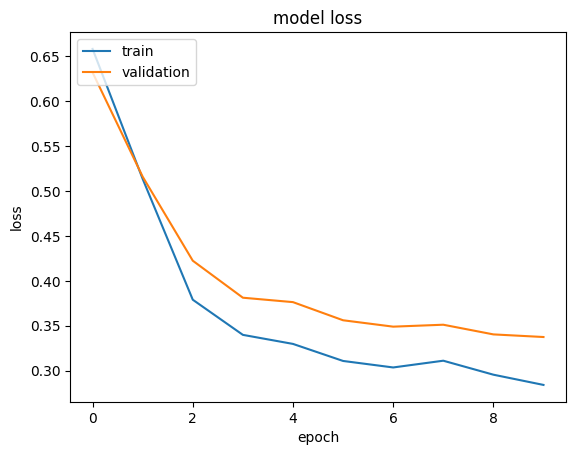

In [26]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Evaluate the model on hold out set

In [27]:
# check model's performance on the validation set
_, acc = model.evaluate(x_val_features,y_val)
print("Validation Accuracy:",acc)

10/10 [==============================] - 0s 11ms/step - loss: 0.3375 - acc: 0.8804
Validation Accuracy: 0.880398690700531


**Inference**

Let us make predictions on the hold out set

In [28]:
# input audio

ind=35
test_audio = x_val[ind]
ipd.Audio(test_audio,rate=16000)

In [29]:
# classification
feature = x_val_features[ind]
prob = model.predict(feature.reshape(1,-1,1))
if (prob[0][0] < 0.5):
  pred='emergency'
else:
  pred='non emergency'

print("Prediction:",pred)

1/1 [==============================] - 0s 245ms/step
Prediction: emergency


<br>

Let's define the model architecture using LSTM layers and the time domain features.

In [30]:
# reshape chunks
x_tr_features  = x_tr.reshape(len(x_tr),-1,160)
x_val_features = x_val.reshape(len(x_val),-1,160)

print("Reshaped Array Size",x_tr_features.shape)

Reshaped Array Size (2701, 200, 160)


In [31]:
from keras.layers import LSTM

# LSTM based deep learning model architecture
def lstm_model(x_tr):

  inputs = Input(shape=(x_tr.shape[1],x_tr.shape[2]))

  #lstm
  x = LSTM(128)(inputs)
  x = Dropout(0.3)(x)

  #dense
  x= Dense(64,activation='relu')(x)
  x= Dense(1,activation='sigmoid')(x)

  model = Model(inputs, x)

  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])

  return model

In [32]:
model = lstm_model(x_tr_features)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 160)]        0         
                                                                 
 lstm (LSTM)                 (None, 128)               147968    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 156289 (610.50 KB)
Trainable params: 156289 (610.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [34]:
history=model.fit(x_tr_features, y_tr, epochs=10,
                  callbacks=[mc], batch_size=32,
                  validation_data=(x_val_features,y_val))

Epoch 1/10
85/85 [==============================] - ETA: 0s - loss: 0.6419 - acc: 0.6372
Epoch 1: val_loss improved from inf to 0.55295, saving model to best_model.hdf5
85/85 [==============================] - 5s 27ms/step - loss: 0.6419 - acc: 0.6372 - val_loss: 0.5530 - val_acc: 0.7741
Epoch 2/10
82/85 [===========================>..] - ETA: 0s - loss: 0.5415 - acc: 0.7378
Epoch 2: val_loss did not improve from 0.55295
85/85 [==============================] - 1s 13ms/step - loss: 0.5427 - acc: 0.7364 - val_loss: 0.6061 - val_acc: 0.6545
Epoch 3/10
83/85 [============================>.] - ETA: 0s - loss: 0.5322 - acc: 0.7323
Epoch 3: val_loss improved from 0.55295 to 0.49698, saving model to best_model.hdf5
85/85 [==============================] - 1s 12ms/step - loss: 0.5305 - acc: 0.7338 - val_loss: 0.4970 - val_acc: 0.7807
Epoch 4/10
81/85 [===========================>..] - ETA: 0s - loss: 0.4813 - acc: 0.7693
Epoch 4: val_loss improved from 0.49698 to 0.41176, saving model to best_

In [35]:
# load best model weights
model.load_weights('best_model.hdf5')

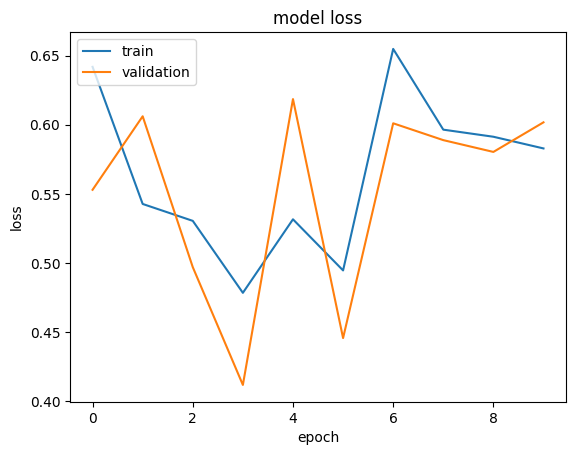

In [36]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [37]:
_,acc = model.evaluate(x_val_features,y_val)
print("Accuracy:",acc)

10/10 [==============================] - 0s 10ms/step - loss: 0.4118 - acc: 0.8206
Accuracy: 0.8205980062484741


## Spectrogram Features

Let us define a function that computes the spectrogram. Before that, we need to understand how the spectrogram is computed.

Spectrogram accepts the raw audio wave and then breaks it into chunks or windows and then applies FFT on each window to compute the frequencies.

Coming to the parameters for computing spectrogram:

* nperseg = Size of the window i.e. number of samples in each chunk
* noverlap= Number of overlapping samples between each window

In [38]:
def log_specgram(audio, sample_rate, eps=1e-10):
    nperseg  = 320
    noverlap = 160

    freqs, times, spec = scipy.signal.spectrogram(audio,fs=sample_rate, nperseg=nperseg,noverlap=noverlap)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Define a function for representing spectrogram:

In [39]:
def plot(spectrogram,label):
  fig = plt.figure(figsize=(14, 8))
  ax = fig.add_subplot(211)
  ax.imshow(spectrogram.T, aspect='auto', extent=[times.min(), times.max(), freqs.min(), freqs.max()])
  ax.set_title('Spectrogram of '+label)
  ax.set_ylabel('Freqs in Hz')
  ax.set_xlabel('Seconds')

Compute the spectrogram:

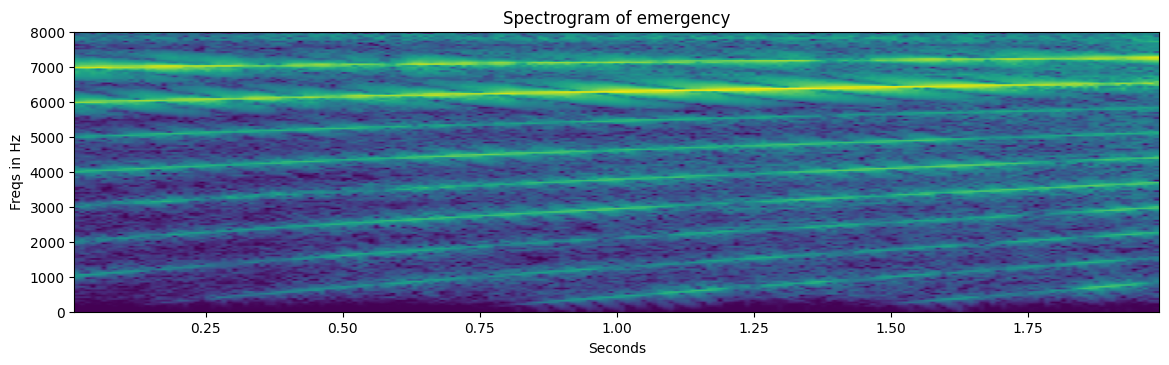

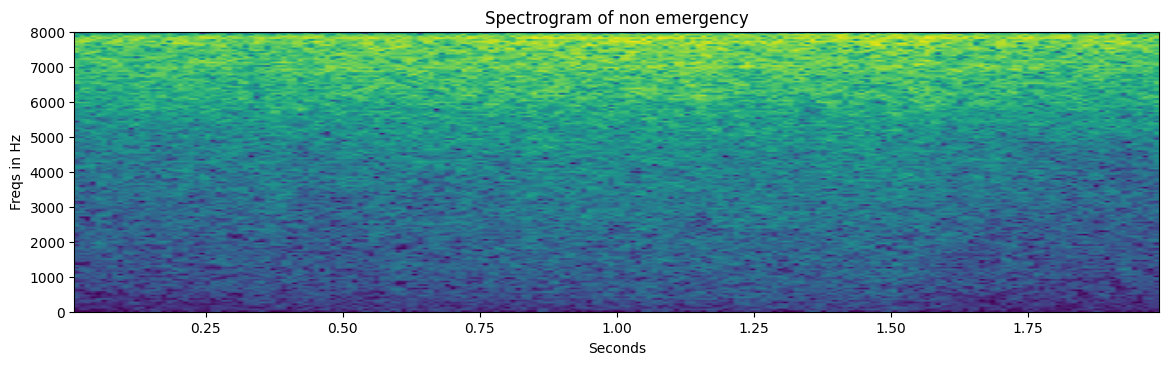

In [40]:
freqs, times, spectrogram = log_specgram(emergency[300], sample_rate)
plot(spectrogram,"emergency")

freqs, times, spectrogram = log_specgram(non_emergency[300], sample_rate)
plot(spectrogram,"non emergency")

In [ ]:
spectrogram.shape

__Extract the spectrogram features__

In [41]:
def extract_spectrogram_features(x_tr):
  features=[]
  for i in x_tr:
    _, _, spectrogram = log_specgram(i, sample_rate)

    mean = np.mean(spectrogram, axis=0)
    std = np.std(spectrogram, axis=0)
    spectrogram = (spectrogram - mean) / std

    features.append(spectrogram)

  return np.array(features)

In [42]:
x_tr_features  = extract_spectrogram_features(x_tr)
x_val_features = extract_spectrogram_features(x_val)

__Call the LSTM Model__

In [43]:
model_2 = lstm_model(x_tr_features)

In [44]:
mc = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Understand the no. of parameters and shape of each layer:

In [45]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 199, 161)]        0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               148480    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 156801 (612.50 KB)
Trainable params: 156801 (612.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Train the model

In [46]:
history=model_2.fit(x_tr_features, y_tr,
                    epochs=10, callbacks=[mc], batch_size=32,
                    validation_data=(x_val_features,y_val))

Epoch 1/10
83/85 [============================>.] - ETA: 0s - loss: 0.6501 - acc: 0.6209
Epoch 1: val_loss improved from inf to 0.59750, saving model to best_model.hdf5
85/85 [==============================] - 4s 19ms/step - loss: 0.6493 - acc: 0.6216 - val_loss: 0.5975 - val_acc: 0.7110
Epoch 2/10
85/85 [==============================] - ETA: 0s - loss: 0.3660 - acc: 0.8615
Epoch 2: val_loss improved from 0.59750 to 0.24041, saving model to best_model.hdf5
85/85 [==============================] - 1s 12ms/step - loss: 0.3660 - acc: 0.8615 - val_loss: 0.2404 - val_acc: 0.9169
Epoch 3/10
81/85 [===========================>..] - ETA: 0s - loss: 0.3434 - acc: 0.8723
Epoch 3: val_loss did not improve from 0.24041
85/85 [==============================] - 1s 17ms/step - loss: 0.3425 - acc: 0.8730 - val_loss: 0.3192 - val_acc: 0.8771
Epoch 4/10
81/85 [===========================>..] - ETA: 0s - loss: 0.2744 - acc: 0.8954
Epoch 4: val_loss improved from 0.24041 to 0.19551, saving model to best_

Load the weights of the best model:

In [47]:
model_2.load_weights('best_model.hdf5')

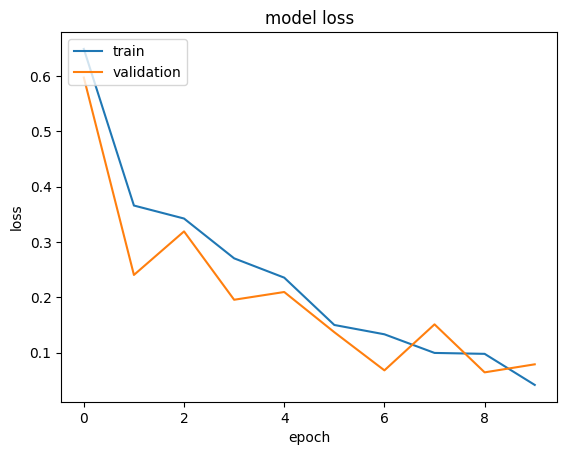

In [48]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Evaluating the performance of the model on validation set:

In [49]:
_,acc = model_2.evaluate(x_val_features,y_val)
print("Accuracy:",acc)

10/10 [==============================] - 0s 9ms/step - loss: 0.0642 - acc: 0.9767
Accuracy: 0.9767441749572754


<br>

Lets train the CNN based model on the same spectrogram features.


In [50]:
model_3, mc = conv_model(x_tr_features)

Understand the input and output shape of each layer:

In [51]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 199, 161)]        0         
                                                                 
 conv1d_2 (Conv1D)           (None, 199, 8)            16752     
                                                                 
 dropout_4 (Dropout)         (None, 199, 8)            0         
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 99, 8)             0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 99, 16)            1424      
                                                                 
 dropout_5 (Dropout)         (None, 99, 16)            0         
                                                           

Training the model:

In [52]:
history=model_3.fit(x_tr_features, y_tr,
                    epochs=10, callbacks=[mc], batch_size=32,
                    validation_data=(x_val_features,y_val))

Epoch 1/10
85/85 [==============================] - ETA: 0s - loss: 0.5609 - acc: 0.7101
Epoch 1: val_loss improved from inf to 0.42905, saving model to best_model.hdf5
85/85 [==============================] - 3s 12ms/step - loss: 0.5609 - acc: 0.7101 - val_loss: 0.4291 - val_acc: 0.8738
Epoch 2/10
79/85 [==========================>...] - ETA: 0s - loss: 0.3147 - acc: 0.8714
Epoch 2: val_loss improved from 0.42905 to 0.31588, saving model to best_model.hdf5
85/85 [==============================] - 1s 7ms/step - loss: 0.3154 - acc: 0.8708 - val_loss: 0.3159 - val_acc: 0.8970
Epoch 3/10
85/85 [==============================] - ETA: 0s - loss: 0.2373 - acc: 0.9041
Epoch 3: val_loss improved from 0.31588 to 0.27109, saving model to best_model.hdf5
85/85 [==============================] - 1s 7ms/step - loss: 0.2373 - acc: 0.9041 - val_loss: 0.2711 - val_acc: 0.9003
Epoch 4/10
79/85 [==========================>...] - ETA: 0s - loss: 0.1720 - acc: 0.9355
Epoch 4: val_loss improved from 0.2710

Load the best saved model

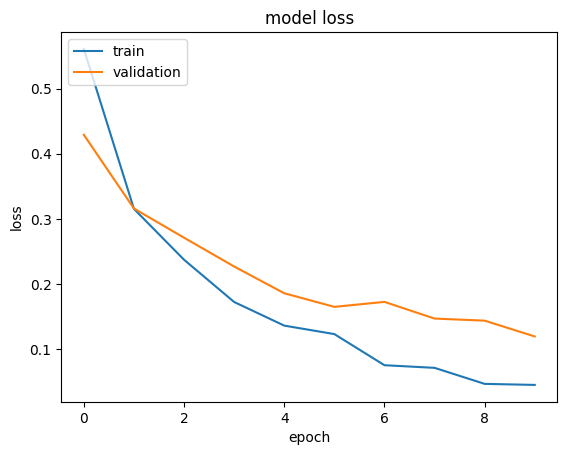

In [53]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Evaluating the performance of the model:

In [54]:
model_3.load_weights('best_model.hdf5')

In [55]:
# model's performance on the validation set
_,acc = model_3.evaluate(x_val_features,y_val)
print("Accuracy:",acc)

10/10 [==============================] - 0s 5ms/step - loss: 0.1195 - acc: 0.9668
Accuracy: 0.9667773842811584


### What else to try?

* Different model architectures
* Use Frequency domain features
* Change input sequence length
* more...